You will recall
my [previous blog post](https://rhodesmill.org/brandon/2018/matplotlib-blit-repair/)
that tried to build the necessary scaffolding
for me to finally write up my 2017 PyCon Ireland keynote
on the structure of the Medieval universe.
It ran into several problems with [matplotlib animations](https://matplotlib.org/3.1.1/api/animation_api.html) —
but, having written that post,
I realized that the problem ran deeper.

How could *any* animation show a Solar System,
when a Solar System’s motion never exactly repeats?
The orbital periods of the planets aren’t exact multiples of each other,
and don’t provide a moment
when the planets reach their original positions
and the animation can repeat.
At whatever moment an animation finished
and looped back to the beginning,
the planets would visibly and jarringly jump back to their original position.

But then I remembered that modern browsers support animation directly,
and thought:
could a python script produce an SVG diagram
with a separate CSS animation for each planet,
that repeated each time that specific planet finished a revolution?

The result would be an animated Solar System
that fits into a few thousand bytes,
would render with perfect clarity,
and runs continuously for as long has the viewer was willing to watch!

But there’s a problem.

The CSS animation mechanism is perfect
for the simplest possible planetary orbit: uniform circular motion.
Here’s a simple SVG diagram in which a planet
and the line connecting it to the origin
are grouped within a single `<g>` element.

In [1]:
%pylab inline
from IPython.display import HTML
𝜏 = 2.0 * pi

circular_svg = '''
<svg version="1.1" width=220 height=220>
 <g transform="translate(110, 110)">
  <circle cx=0 cy=0 r=100 stroke=lightgray stroke-width=1 fill=none />
  <g class="anim %s">
   <line x1=0 y1=0 x2=100 y2=0 stroke=lightgray />
   <circle cx=100 cy=0 r=5 fill=#bb0 />
  </g>
  <circle cx=0 cy=0 r=3 fill=#040 />
 </g>
</svg>
'''

HTML(circular_svg % 'stationary')

Populating the interactive namespace from numpy and matplotlib


We use `translate()` to move (0,0) to the middle of the diagram
where it can serve as the circle’s center.
We paint a big circle for the orbit,
small circles to mark the orbit’s center and a planet,
and a line to link them.

Note, in passing, the great glory of embedding SVG in HTML — such elegance!
While raw SVG files are required to be noisy and bureaucratic XML,
SVG embedded in HTML is instead parsed using the same ergonomic SGML rules
that are used to parse HTML itself.
It requires no `xmlns:` declaration,
no double quote noise around simple words and numbers,
and — most importantly for our purposes —
supports its own `<style>` element without any `CDATA`.

We can animate this SVG using just a few lines of CSS:


In [2]:
circular_style = '''
<style>
.anim {
 animation-duration: 10s;
 animation-iteration-count: infinite;
} 
.uniform {
 animation-name: uniform;
 animation-timing-function: linear;
}
@keyframes uniform {
 to {transform: rotate(360deg);}
}
</style>
'''

HTML(circular_svg % 'uniform' + circular_style)

The result is perfect uniform circular motion,
that will run forever in the browser without any further work.

So what's the problem?

The problem is that the ancient Greeks determined, alas,
that none of the planets proceeds across the sky
with uniform circular motion.
The planets that come closest —
the Moon and Sun —
are still not perfectly uniform in their motion,
running faster on one side of their orbit and slower on the other.
(The Greeks defined a “planet”
as any object that moves against the background of stars,
so the Sun and Moon qualified as planets.)

To better model the planets’ motion,
a Greek scientist named Claudius Ptolemy
living in the Greek colonial city of Alexandria in Egypt
invented the *equant*:
the idea that the center of uniform circular motion
might be a different point than the center of the orbit.
An equant offset from the orbit’s center
would make the planet faster on one side of its orbit
and slower on the other side,
exactly as observed.

Which raises a problem for us:
can the equant be animated using CSS?

It’s easy enough, at least, to construct the static diagram.
We now have two centers.
The planet rides along the circle, as before,
but the moving line that sweeps at a uniform rate
is now centered off to the right.
Its motion, happily, can be animated by the CSS we’ve already written.


In [3]:
equant_svg = '''
<svg version="1.1" width=300 height=220>
 <g transform="translate(110, 110)">
  <circle cx=0 cy=0 r=2 fill=gray />
  <circle cx=0 cy=0 r=100 stroke=lightgray stroke-width=1 fill=none />
  <g class="anim %s">
   <circle cx=100 cy=0 r=5 fill=#bb0 />
  </g>
  <g transform="translate(%s, 0)">
   <circle cx=0 cy=0 r=2 fill=gray />
   <g class="anim uniform">
    <line x1=0 y1=0 x2=%s y2=0 stroke=lightgray />
   </g>
  </g>
 </g>
</svg>
'''

HTML(equant_svg % ('stationary', 70, 170))

The problem is getting the planet to move.
Its motion will now have to be more complicated,
because uniform circular motion won’t keep it aligned
with the equant’s revolution:


In [4]:
HTML(equant_svg % ('uniform', 70, 170))

As you can see,
a planet with uniform circular motion
runs ahead of the equant for half of its orbit
and then falls behind schedule for the remaining half.

Unfortunately CSS makes no provision for this special sort of motion;
its `animation-timing-function` does not allow the value `"equant"`.
But it does offer one alternative:
motion can be specified using a Bézier curve.

Can Python’s numeric ecosystem
help us generate the right Bézier parameters
to animate the equant?

From the
[Wikipedia’s entry on the Equant](https://en.wikipedia.org/wiki/Equant)
we can learn the formula
that relates the angle *M* of the uniform circular motion
to the angle *E* of the planet along its orbit:


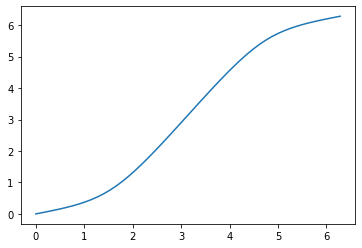

In [6]:
def equant_E(M, e):
    return M - arcsin(e * np.sin(M))

M = linspace(0, 𝜏)
E = equant_E(M, 0.7)
plot(M, E);

The curve has exactly the shape we expect:
the planet moves slowly at first,
accelerates to its maximum speed (steepest slope)
at ½𝜏 —
the point on its orbit farthest from the equant —
then slows again until it reaches its starting point at an angle of 𝜏.

The tool that CSS offers for controlling an animation’s speed
is a cubic spline starting at the coordinate (0,0)
and ending at (1,1).
Substituting these fixed coordinates
into the generic formula on
[the Wikipedia’s Bézier Curve page](https://en.wikipedia.org/wiki/B%C3%A9zier_curve),
we get:


In [7]:
def bezier(t, x1, y1, x2, y2):
    m = 1 - t
    p = 3 * m * t
    b, c, d = p * m, p * t, t * t * t
    return (b * x1 + c * x2 + d,
            b * y1 + c * y2 + d)

The curve’s formula is specially designed
so that the curve leaves the origin with an angle and velocity
determined by the line from (0,0) to (*x*₁,*y*₁),
then dives in towards its destination
at an angle and speed determined by the line from (*x*₂,*y*₂) to (1,1).
For example,
we can ask the curve to launch out at a low angle along the x-axis
then move up to the top of the diagram
to finish with a similar horizontal approach to its endpoint —
producing a spline that reminds us of the equant’s motion:


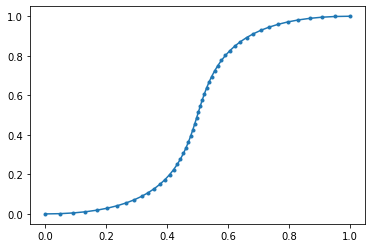

In [8]:
t = linspace(0, 1)
xb, yb = bezier(t, 0.8, 0, 0.2, 1)
plot(xb, yb, '.-')

Can Python help us refine the positions
of the points (*x*₁,*y*₁) and (*x*₂,*y*₂)
so the spline approximates the shape of the equant?

SciPy provides a `curve_fit()` function
that searches for the parameters that will make one curve
as close as possible to the shape of a target curve,
but it carries a requirement:
the target curve and the test curve
both need to provide *y* values
that correspond to the same set of *x*’s —
or, in our case, to the same input *M* array.

The Bézier curve we’ve produced, alas,
does not satisfy this criterion.
A Bézier curve is rather independently minded
about both its *x*’s and its *y*’s.
Driven by its input parameter *t*,
the Bézier’s output *x* and *y* coordinates
make their own decisions
about whether to space themselves close together or far apart
as the curve swings from its origin to its destination.
You can see that the example curve above
starts at a high velocity with points spaced far apart,
slows down in the middle as the curve moves steeply upward
and points come close together,
then finishes by accelerating again to its destination at the upper right.
We need *x*’s spaced evenly instead.

Fortunately, NumPy has a solution!
It offers an interpolation routine
that takes a curve as input
and uses it to interpolate *y* positions for a new input array *x*.
What happens if we ask for the Bézier curve
to be mapped atop our input array *M*?


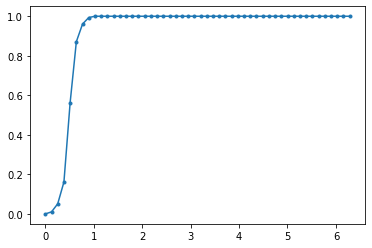

In [9]:
plot(M, interp(M, xb, yb), '.-')

Whoops.

The result looks rather comic:
the entire Bézier curve has been squashed
into only about one-sixth of the range of *M*.
We forgot that our input arrays
have two completely different domains:
uniform circular motion *M* runs from 0 to 𝜏,
while a CSS Bézier curve runs from 0 to 1.

The Bézier curve needs to be scaled up
to cover the entire domain of *M*:


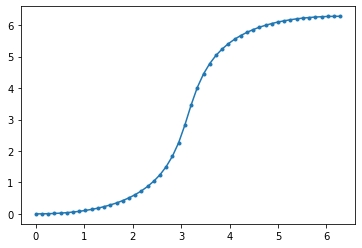

In [11]:
plot(M, interp(M, xb * 𝜏, yb * 𝜏), '.-')

To let `curve_fit()` do its job successfully,
let's create a wrapper
that scales points between *M*₀ and *M*₁
into the range [0,1] for input to the Bézier function,
and whose output range [0,1] is then expanded to produce output between *E*₀ and *E*₁.


In [13]:
def scaled_bezier(M0, M1, E0, E1):
    def bez(M, x1, y1, x2, y2):
        t = linspace(0, 1)
        xb, yb = bezier(t, x1, y1, x2, y2)
        x = (M - M0) / (M1 - M0)
        y = interp(x, xb, yb)
        return E0 + (E1 - E0) * y
    return bez

We can now ask SciPy
to find Bézier curve
that approximates the equant:


In [14]:
from scipy.optimize import curve_fit

bez = scaled_bezier(0, 𝜏, 0, 𝜏)
guess = [0.5, 0.0, 0.5, 1.0]
args, v = curve_fit(bez, M, E, guess, bounds=[0,1])
args

array([0.47532029, 0.06537691, 0.52467971, 0.93462309])

Success!
The Bézier curve, shown here in orange,
looks like a fairly close approximation for the equant:

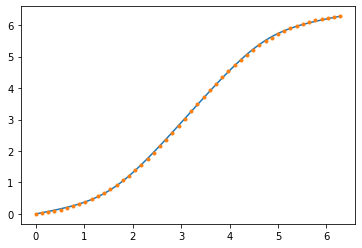

In [15]:
plot(M, E)
plot(M, bez(M, *args), '.')

How closely will the resulting animation
represent the true rotation of the equant?


In [17]:
max(abs(E - bez(M, *args))) * 360 / 𝜏

1.980801996224498

This indicates that at the worst spots,
this curve will lead or lag the true rotation
by almost 2° of arc.
Will that be noticeable?
Let’s take a look!
Here’s CSS that will use a custom animation function
to control rotation speed:


In [18]:
bezier1_css = '''
<style>
.bezier1 {
  animation-name: bezier1;
}
@keyframes bezier1 {
 from {animation-timing-function: %s}
 to {transform: rotate(360deg)}
}
</style>
'''

And a routine to properly format the parameters themselves:


In [19]:
def cb(args):
    argstr = ', '.join('%.3f' % n for n in args)
    return 'cubic-bezier(%s)' % argstr

cb(args)

'cubic-bezier(0.475, 0.065, 0.525, 0.935)'

Does the result produce an equant and a planet
that appear to rotate together?


In [20]:
css = bezier1_css % cb(args)
HTML(equant_svg % ('bezier1', 70, 170) + css)

Drat.

The result is uninspiring.
The planet clearly lags behind, then moves ahead of,
the target set by the sweeping line of the equant.
It turns out that 2° is pretty noticeable.

There is an old rule
for approximating motion with a Bézier curve:
if one curve doesn’t work,
then try more!

I tried two curves;
the improvement was not enough.
So I tried three,
and the result is much better.
Here’s a quick loop
that splits our curve into three
at the *M* values ⅓𝜏 and ⅔𝜏,
and finds the Bézier parameters for each third of the curve.
The result will be 3 `keyframes`
that run in succession,
each controlled by a different Bézier curve.


In [21]:
KEYFRAME = '''\
%.3f%% {
 transform: rotate(%.3frad);
 animation-timing-function: %s;
}
'''

boundaries = [0, 𝜏/3, 2*𝜏/3, 𝜏]
keyframes = []
for M0, M1 in zip(boundaries[:-1], boundaries[1:]):
    M = linspace(M0, M1)
    E = equant_E(M, 0.7)
    bez = scaled_bezier(M0, M1, E[0], E[-1])
    args, v = curve_fit(bez, M, E, bounds=[0,1])
    percent = M0 / 𝜏 * 100
    keyframe = KEYFRAME % (percent, E[0], cb(args))
    keyframes.append(keyframe)
    
print(''.join(keyframes))

0.000% {
 transform: rotate(0.000rad);
 animation-timing-function: cubic-bezier(0.480, 0.206, 0.681, 0.333);
}
33.333% {
 transform: rotate(1.443rad);
 animation-timing-function: cubic-bezier(0.298, 0.264, 0.702, 0.736);
}
66.667% {
 transform: rotate(4.840rad);
 animation-timing-function: cubic-bezier(0.319, 0.667, 0.520, 0.794);
}



The CSS otherwise looks the same as before.


In [22]:
bezier2_css = '''
<style>
.bezier2 {
  animation-name: bezier2;
}
@keyframes bezier2 {
 %s
 to {transform: rotate(360deg)}
}
</style>
'''

But, this time, the visual output is stunning!
The planet seems to follow the equant’s motion perfectly,
moving slowly when close to the equant point,
and very rapidly when on the opposite side of its orbit.


In [23]:
css = bezier2_css % ''.join(keyframes)
html = equant_svg % ('bezier2', 70, 170) + css
HTML(html)

And the best part
is that the animation does not involve matplotlib,
isn’t delivered as raster graphics,
and won’t involve a trade-off between file size and visual quality.
Instead, we’ve delivered it to the browser
using less than 1k characters!


In [24]:
len(html)

892

And in return we enjoy a crisp and accurate animation.

With this technique,
I'm now ready to move forward!
Finally, after these years of delay,
I’ll use my next few blog posts
to build from these simpler pieces
a complete Ptolemaic model of the solar system —
all animated in the browser
without any  matplotlib involved.
